# 📊 공모주 앱 리뷰 NLP 분석

분석 흐름
1) 리뷰 데이터 수집 및 구조화(이전 Notebook)
2) 감성 라벨링 및 분포 검증
3) 워드클라우드 기반 키워드 분석
4) LDA 토픽 모델링
5) Word2Vec 의미 구조 분석

# 📌 1. 데이터 로드 및 기본 전처리

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib

train_df = pd.read_csv("./data/all_review.csv", encoding="utf-8-sig")

train_df.head()
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450 entries, 0 to 449
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   리뷰일     450 non-null    object 
 1   앱이름     450 non-null    object 
 2   별점      450 non-null    float64
 3   사용자 리뷰  450 non-null    object 
 4   회사 응답   450 non-null    object 
dtypes: float64(1), object(4)
memory usage: 17.7+ KB


In [2]:
import warnings

# sklearn / gensim tokenizer 관련 경고 숨기기
warnings.filterwarnings("ignore", category=UserWarning)

# pandas SettingWithCopyWarning 숨기기
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

# FutureWarning 숨기기 (라이브러리 내부 경고)
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
# 분석에 사용하지 않는 컬럼 제거
train_df = train_df.drop('회사 응답', axis=1)

# 별점 기반 규칙형 감성 라벨링
# 모델 기반 감성 분석 대신 해석 가능성을 위해 rule-based 방식 적용
train_df['긍정'] = train_df['별점'].apply(lambda x: 1 if x >= 4 else 0)

train_df.head()

,리뷰일,앱이름,별점,사용자 리뷰,긍정
0,2025-12-25,공모주일정,5.0,요 앱이 얼마나 유용한지는 써보고 실제 활용해 보면 알게 됩니다. 설치한지 1년이 ...,1
1,2025-12-21,공모주일정,5.0,설치해서 사용하다보니 이 앱이야 말로 제 인생에서 가장 필요한 앱이었다는걸 알게 되...,1
2,2025-12-21,공모주일정,1.0,광고가 너무길다,0
3,2025-12-16,공모주일정,4.0,이거 유료버전은 없나요?,1
4,2025-12-05,공모주일정,5.0,돈버는앱,1


# 📌 2. 앱별 긍·부정 리뷰 분포 확인

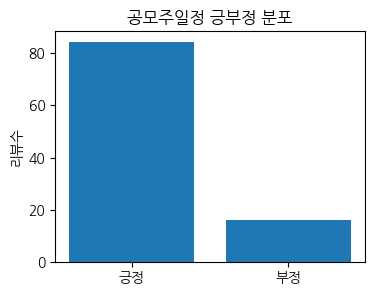

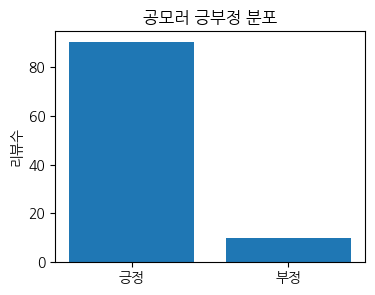

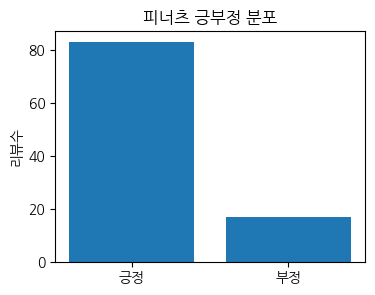

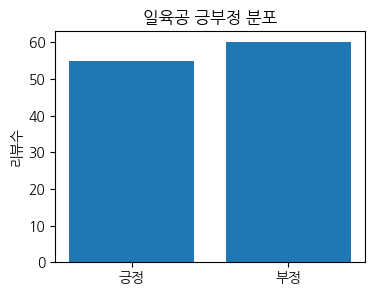

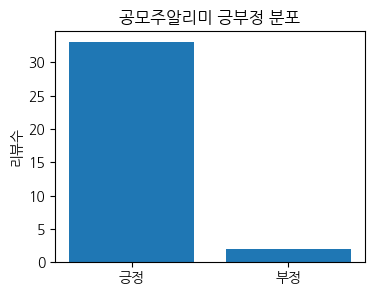

In [4]:
pos_neg_dict = {}

apps = train_df['앱이름'].unique()

for app in apps:

    pos = train_df[(train_df['앱이름'] == app) & (train_df['긍정'] == 1)]
    neg = train_df[(train_df['앱이름'] == app) & (train_df['긍정'] == 0)]

    pos_neg_dict[app] = dict(pos=pos, neg=neg)

    plt.figure(figsize=(4,3))
    plt.bar(['긍정', '부정'], [pos.shape[0], neg.shape[0]])
    plt.title(f"{app} 긍부정 분포")
    plt.ylabel("리뷰수")
    plt.show()

# 📌 3. 텍스트 정제 (Cleaning)

In [5]:
import re

def text_clean(x):
    # 한글/영문/숫자 외 문자 제거 → 형태소 분석 안정화 목적
    cleaned = re.sub(r'[^가-힣a-zA-Z0-9]', " ", x)
    cleaned = cleaned.replace("  ", " ").strip()
    return cleaned

# 앱별 pos/neg 모든 데이터에 동일 전처리 적용
for app, pn in pos_neg_dict.items():
    for key in ['pos','neg']:
        df = pn[key]
        df.loc[:, '사용자 리뷰'] = df['사용자 리뷰'].apply(text_clean)

# 📌 4. 형태소 분석 및 워드클라우드

In [6]:
from konlpy.tag import Mecab
from wordcloud import WordCloud
from collections import Counter

# 명사 중심 분석을 위한 Mecab 사용
mecab = Mecab()

# 앱명/서비스명 등 분석 의미가 낮은 단어 제거
stopwords = set(['공모주','공모','어플','앱','서비스','감사','최고','사용','이번','오늘'])


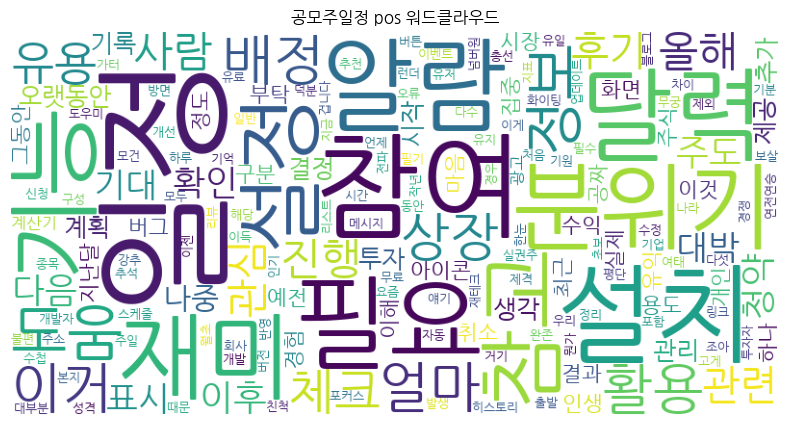

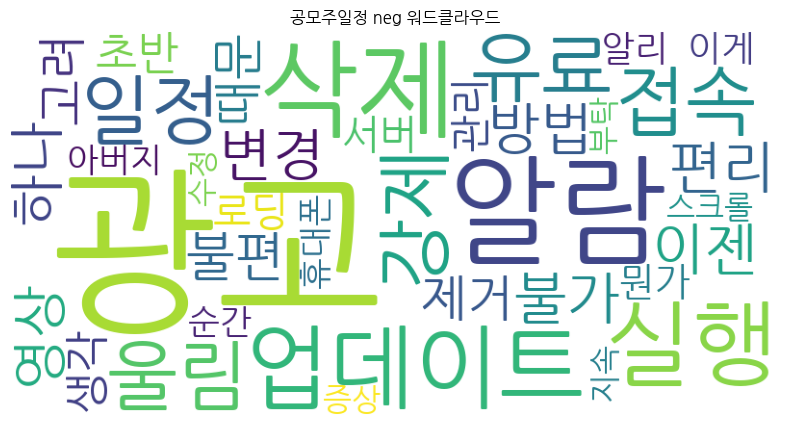

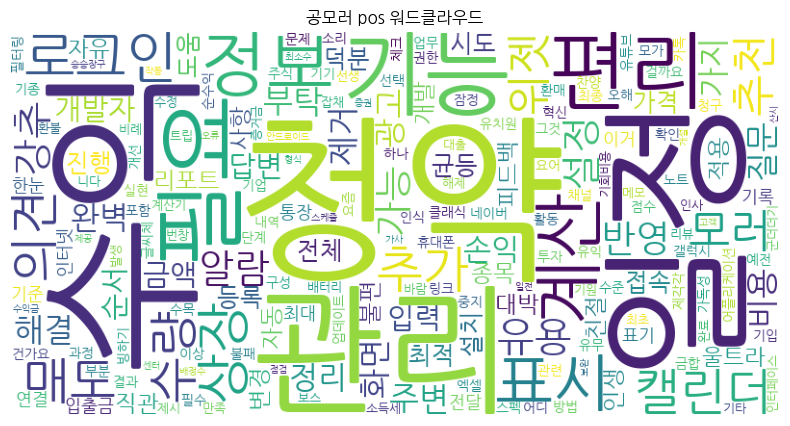

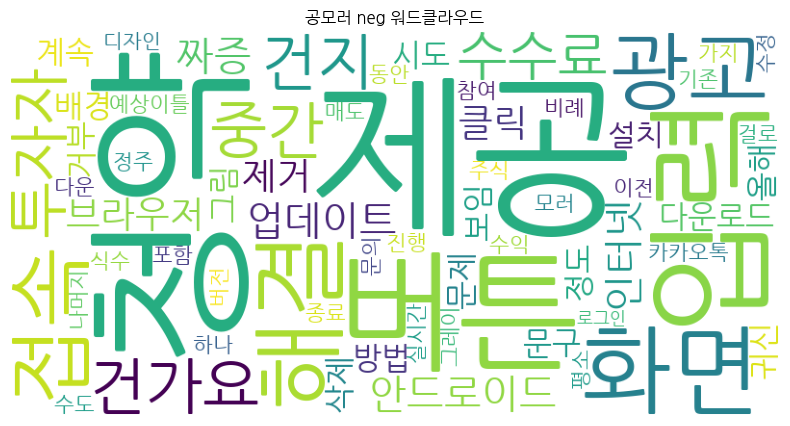

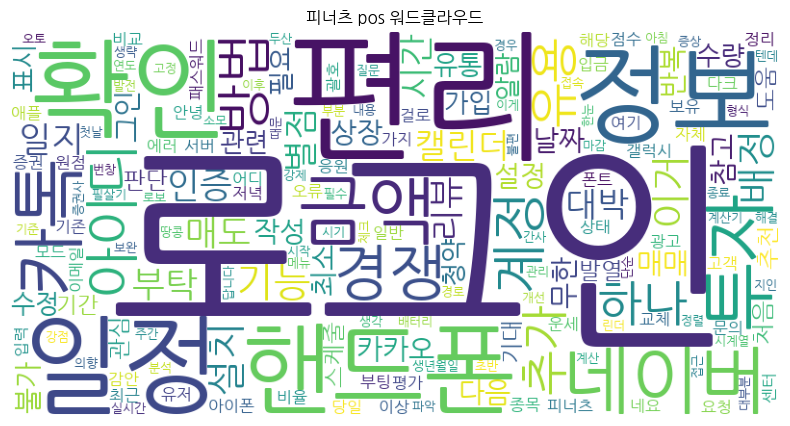

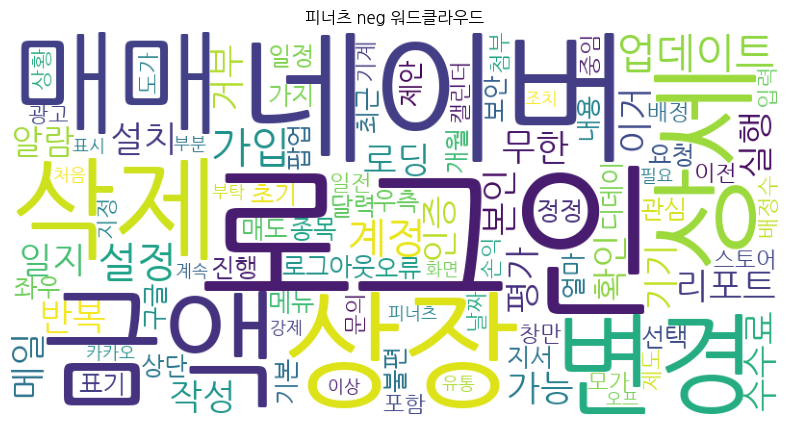

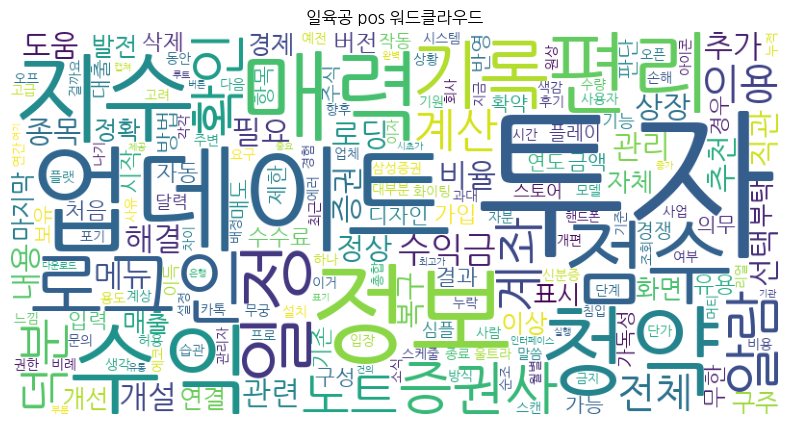

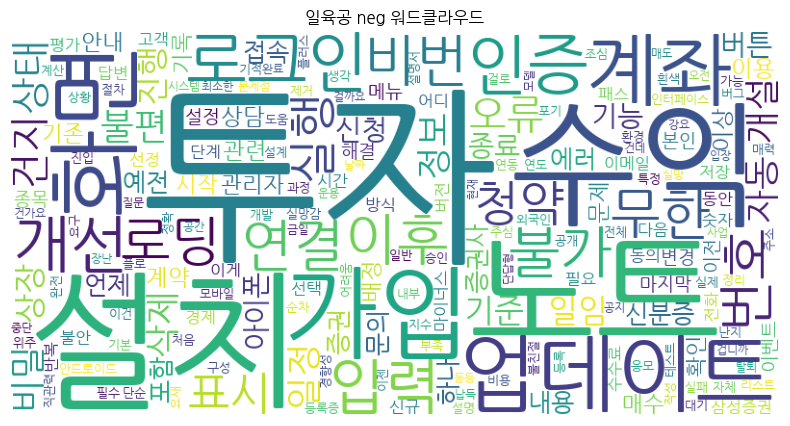

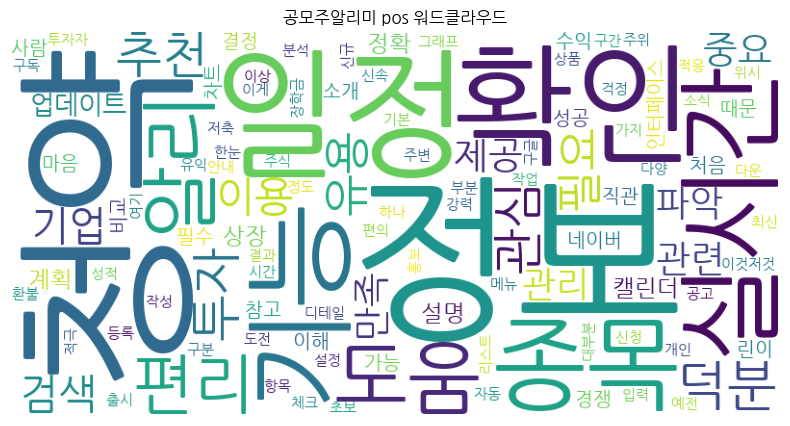

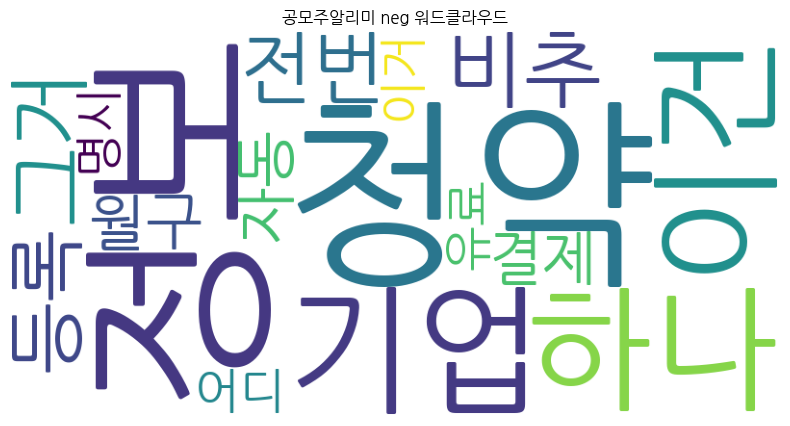

In [7]:
for app, pn in pos_neg_dict.items():
    for label, df in pn.items():

        # 리뷰 텍스트 전체 결합
        full_text = " ".join(df['사용자 리뷰'].tolist())

        # 명사 추출 → UX 기능 중심 키워드 파악 목적
        nouns = mecab.nouns(full_text)

        # 길이 필터 + stopwords 제거
        filtered = [w for w in nouns if len(w)>1 and w not in stopwords]

        # 단어 빈도 계산
        word_freq = Counter(filtered)

        # 워드클라우드 시각화
        wc = WordCloud(
            font_path='NanumGothic.ttf',
            background_color='white',
            width=800,
            height=400
        ).generate_from_frequencies(word_freq)

        plt.figure(figsize=(10,5))
        plt.imshow(wc)
        plt.axis('off')
        plt.title(f"{app} {label} 워드클라우드")
        plt.show()

# 📌 5. LDA 토픽 모델링 및 최적 토픽 수 탐색

In [8]:
from gensim.models import CoherenceModel
from gensim import corpora
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [9]:
def tokenize_texts(texts):
    return [
        [word for word in mecab.nouns(doc)
         if len(word) > 1 and word not in stopwords]
        for doc in texts
    ]

In [10]:
def find_optimal_topics(texts, start=2, end=8, plot=True):

    tokenized_texts = tokenize_texts(texts)
    dictionary = corpora.Dictionary(tokenized_texts)

    vectorizer = CountVectorizer(
        tokenizer=lambda x: x,
        token_pattern=None,
        lowercase=False
    )

    doc_term_matrix = vectorizer.fit_transform(tokenized_texts)

    scores = []
    topic_nums = []

    best_score = -1
    best_n = start

    for n_topics in range(start, end+1):

        lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=42)
        lda_model.fit(doc_term_matrix)

        feature_names = vectorizer.get_feature_names_out()
        topics = [[feature_names[i] for i in topic.argsort()[:-11:-1]] 
                  for topic in lda_model.components_]

        cm = CoherenceModel(
            topics=topics,
            texts=tokenized_texts,
            dictionary=dictionary,
            coherence="c_v"
        )

        score = cm.get_coherence()

        scores.append(score)
        topic_nums.append(n_topics)

        print(f"토픽수: {n_topics}, Coherence Score: {score:.4f}")

        if score > best_score:
            best_score = score
            best_n = n_topics

    print(f"최적 토픽수: {best_n} (Score: {best_score:.4f})")

    # 🔥 시각화 추가
    if plot:
        plt.figure(figsize=(6,4))
        plt.plot(topic_nums, scores, marker='o')
        plt.xlabel("토픽 수")
        plt.ylabel("Coherence Score")
        plt.title("최적 토픽 수 탐색")
        plt.show()

    return best_n


🔥 [공모주일정] 전체 리뷰 기준 최적 토픽수 탐색
토픽수: 2, Coherence Score: 0.4718
토픽수: 3, Coherence Score: 0.4140
토픽수: 4, Coherence Score: 0.4288
토픽수: 5, Coherence Score: 0.4081
토픽수: 6, Coherence Score: 0.4076
토픽수: 7, Coherence Score: 0.4199
토픽수: 8, Coherence Score: 0.3797
최적 토픽수: 2 (Score: 0.4718)


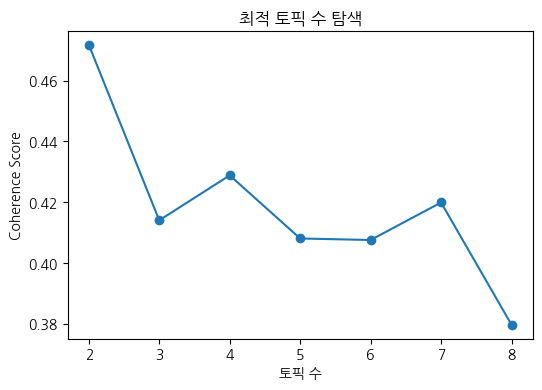


👉 [공모주일정] 최적 토픽수: 2

🔥 [공모러] 전체 리뷰 기준 최적 토픽수 탐색
토픽수: 2, Coherence Score: 0.3669
토픽수: 3, Coherence Score: 0.3168
토픽수: 4, Coherence Score: 0.3419
토픽수: 5, Coherence Score: 0.3227
토픽수: 6, Coherence Score: 0.3871
토픽수: 7, Coherence Score: 0.3789
토픽수: 8, Coherence Score: 0.3483
최적 토픽수: 6 (Score: 0.3871)


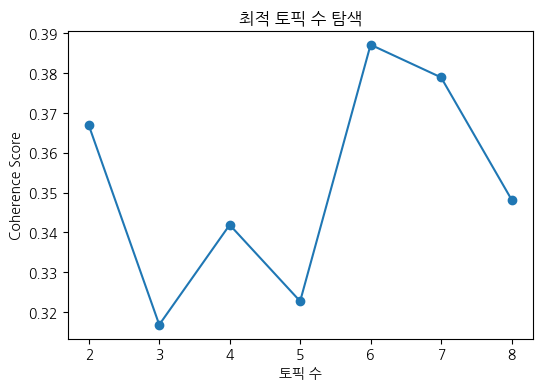


👉 [공모러] 최적 토픽수: 6

🔥 [피너츠] 전체 리뷰 기준 최적 토픽수 탐색
토픽수: 2, Coherence Score: 0.3858
토픽수: 3, Coherence Score: 0.4427
토픽수: 4, Coherence Score: 0.4318
토픽수: 5, Coherence Score: 0.3935
토픽수: 6, Coherence Score: 0.4107
토픽수: 7, Coherence Score: 0.4575
토픽수: 8, Coherence Score: 0.4134
최적 토픽수: 7 (Score: 0.4575)


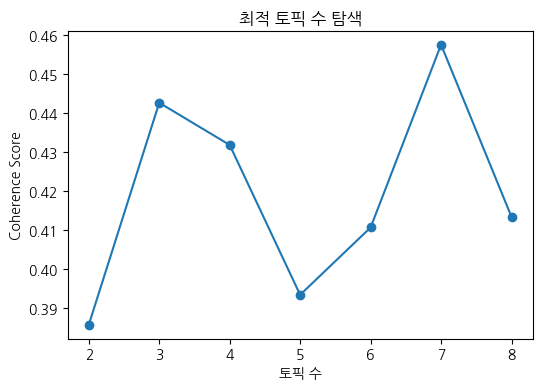


👉 [피너츠] 최적 토픽수: 7

🔥 [일육공] 전체 리뷰 기준 최적 토픽수 탐색
토픽수: 2, Coherence Score: 0.3197
토픽수: 3, Coherence Score: 0.3109
토픽수: 4, Coherence Score: 0.3694
토픽수: 5, Coherence Score: 0.3752
토픽수: 6, Coherence Score: 0.3780
토픽수: 7, Coherence Score: 0.4151
토픽수: 8, Coherence Score: 0.3635
최적 토픽수: 7 (Score: 0.4151)


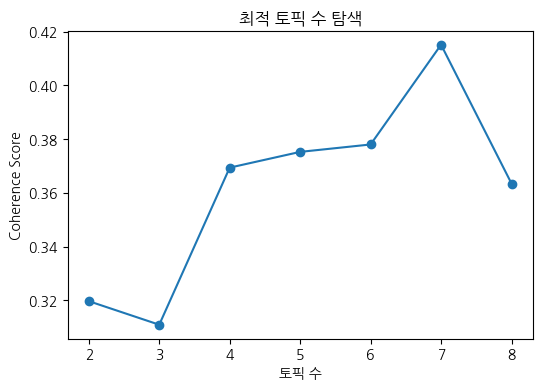


👉 [일육공] 최적 토픽수: 7

🔥 [공모주알리미] 전체 리뷰 기준 최적 토픽수 탐색
토픽수: 2, Coherence Score: 0.5599
토픽수: 3, Coherence Score: 0.4622
토픽수: 4, Coherence Score: 0.5029
토픽수: 5, Coherence Score: 0.5078
토픽수: 6, Coherence Score: 0.5200
토픽수: 7, Coherence Score: 0.5878
토픽수: 8, Coherence Score: 0.4900
최적 토픽수: 7 (Score: 0.5878)


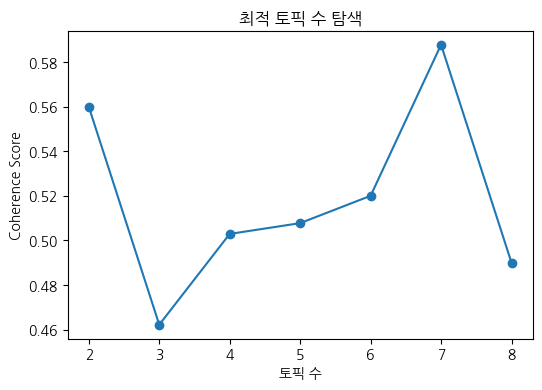


👉 [공모주알리미] 최적 토픽수: 7


In [11]:
for ipo_eng, pn in pos_neg_dict.items():

    print("\n", "="*80)
    print(f"🔥 [{ipo_eng}] 전체 리뷰 기준 최적 토픽수 탐색")
    print("="*80)

    # ⭐️ pos + neg 합치기 (앱 단위 분석)
    texts = []

    for senti in pn:
        texts.extend(pn[senti]['사용자 리뷰'].dropna().tolist())

    # 리뷰 너무 적으면 스킵
    if len(texts) < 20:
        print("리뷰 부족 → 스킵")
        continue

    # 🔥 그래프 + 최적 토픽수 출력
    best_k = find_optimal_topics(texts, start=2, end=8, plot=True)

    print(f"\n👉 [{ipo_eng}] 최적 토픽수:", best_k)

In [12]:
best_k_dict = {
    '공모주일정': 2,
    '공모러': 6,
    '피너츠': 7,
    '일육공': 7,
    '공모주알리미': 7
}

# 📌 6. Word2Vec + t-SNE 의미 구조 분석

In [13]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE

from gensim.models import Word2Vec

In [14]:
# 전체 리뷰 기반 Word2Vec 학습
# → 단어 간 의미적 유사성 공간 생성
all_reviews = train_df['사용자 리뷰'].dropna().tolist()
all_tokenized = tokenize_texts(all_reviews)

w2v_model = Word2Vec(
    sentences=all_tokenized,
    vector_size=100,
    window=5,
    min_count=2,
    workers=4,
    sg=1)

In [15]:
print("📌 Word2Vec 학습 시작")

all_reviews = train_df['사용자 리뷰'].dropna().tolist()
all_tokenized = tokenize_texts(all_reviews)

w2v_model = Word2Vec(
    sentences=all_tokenized,
    vector_size=100,
    window=5,
    min_count=2,
    workers=4,
    sg=1
)

print("✅ Word2Vec 학습 완료")

📌 Word2Vec 학습 시작
✅ Word2Vec 학습 완료



📊 [공모주일정] (pos) t-SNE 시각화 시작 / 토픽수=2


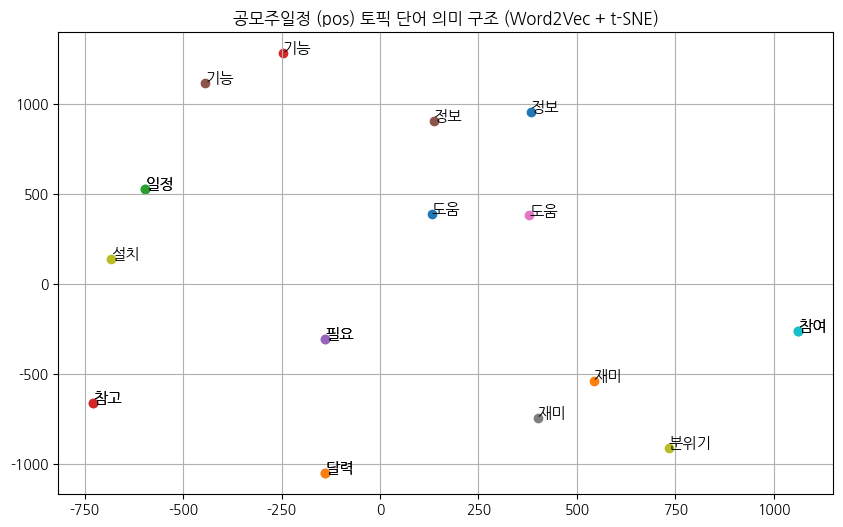

공모주일정 (neg) 리뷰 부족 - 스킵

📊 [공모러] (pos) t-SNE 시각화 시작 / 토픽수=6


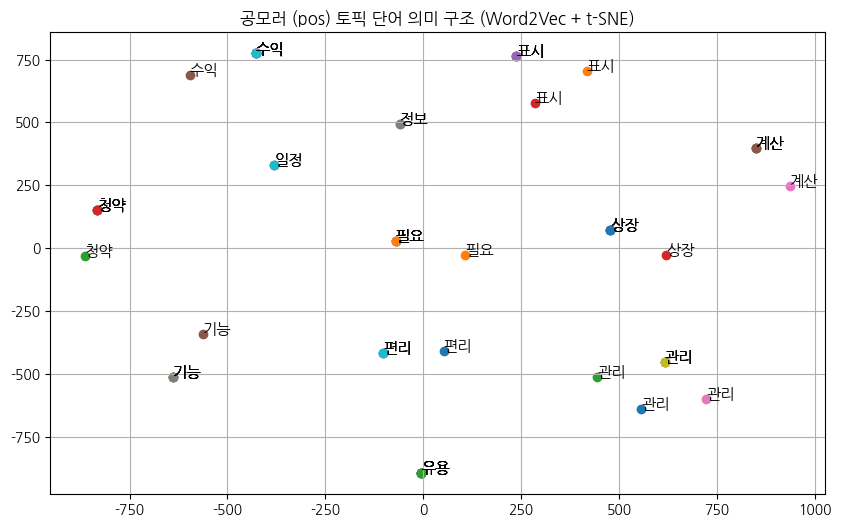

공모러 (neg) 리뷰 부족 - 스킵

📊 [피너츠] (pos) t-SNE 시각화 시작 / 토픽수=7


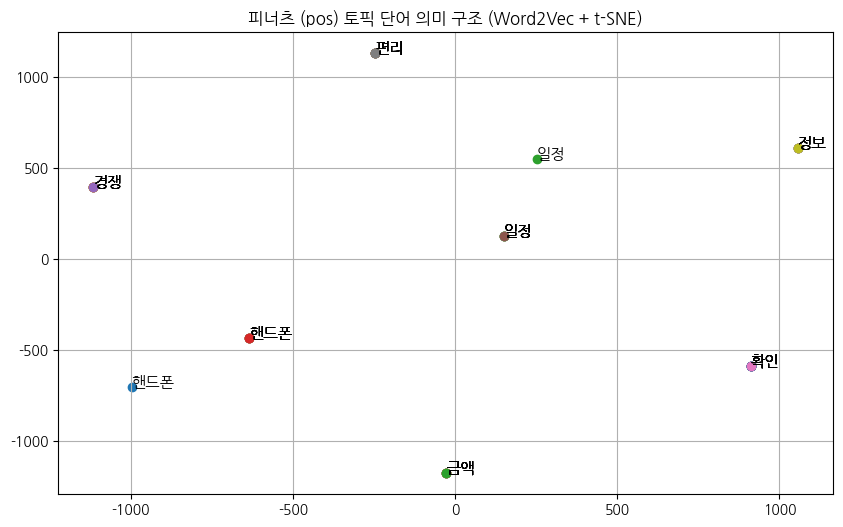

피너츠 (neg) 리뷰 부족 - 스킵

📊 [일육공] (pos) t-SNE 시각화 시작 / 토픽수=7


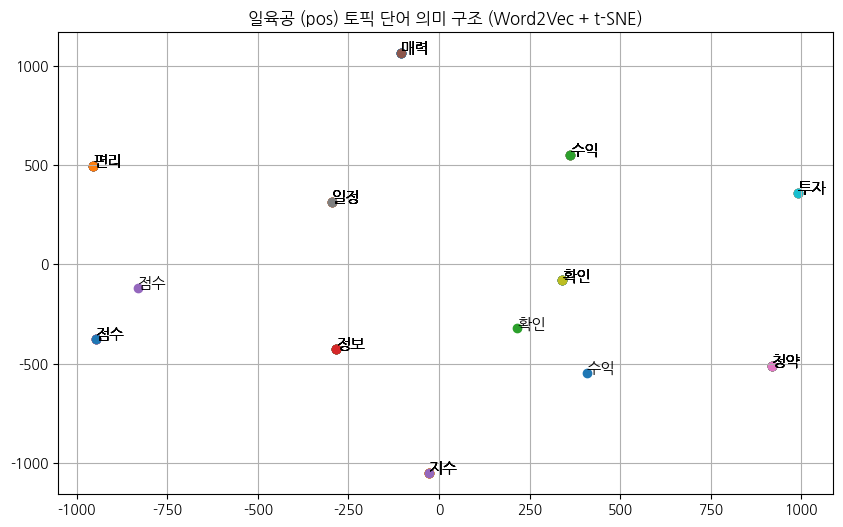


📊 [일육공] (neg) t-SNE 시각화 시작 / 토픽수=7


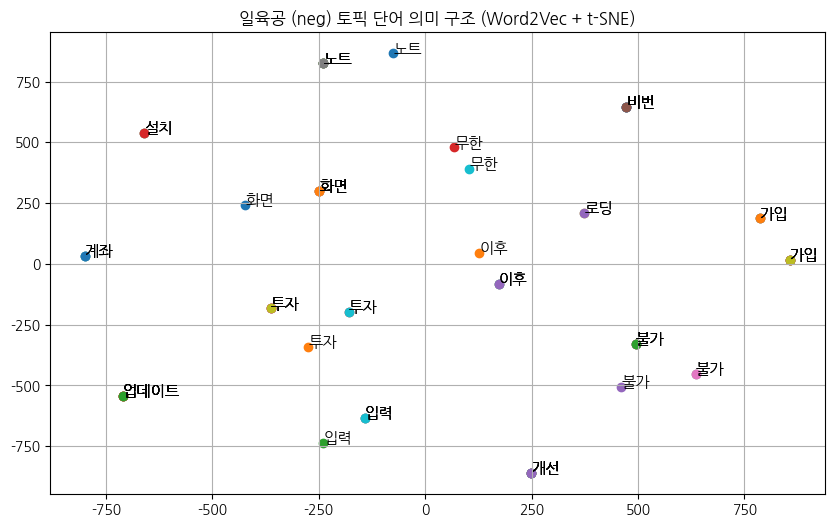


📊 [공모주알리미] (pos) t-SNE 시각화 시작 / 토픽수=7


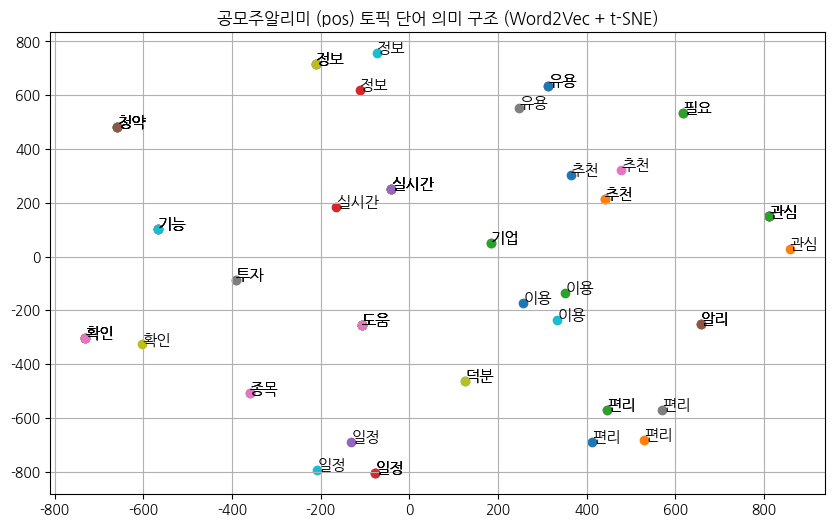

공모주알리미 (neg) 리뷰 부족 - 스킵

✅ 모든 t-SNE 시각화 완료


In [16]:
for ipo_eng, pn in pos_neg_dict.items():
    for senti, df_senti in pn.items():

        texts_series = df_senti['사용자 리뷰'].dropna()

        if len(texts_series) < 20:
            print(f"{ipo_eng} ({senti}) 리뷰 부족 - 스킵")
            continue

        texts = texts_series.tolist()

        # ⭐️ 이미 계산된 최적 토픽수 사용
        best_k = best_k_dict.get(ipo_eng, 5)

        print(f"\n📊 [{ipo_eng}] ({senti}) t-SNE 시각화 시작 / 토픽수={best_k}")

        # =====================================
        # LDA용 토큰화
        # =====================================
        tokenized_texts = tokenize_texts(texts)

        vectorizer = CountVectorizer(
            tokenizer=lambda x: x,
            token_pattern=None,
            lowercase=False,
            max_df=0.9,
            min_df=5
        )

        review_vec = vectorizer.fit_transform(tokenized_texts)

        if review_vec.shape[1] == 0:
            print("단어 부족 - 스킵")
            continue

        lda_model = LatentDirichletAllocation(
            n_components=best_k,
            random_state=42
        )

        lda_model.fit(review_vec)

        words = vectorizer.get_feature_names_out()

        # =====================================
        # 토픽별 상위 단어 수집
        # =====================================
        topic_words = []
        topic_ids = []

        for t_idx, topic in enumerate(lda_model.components_):
            top_indices = topic.argsort()[-10:]
            top = [words[idx] for idx in top_indices]

            for w in top:
                topic_words.append(w)
                topic_ids.append(t_idx)

        # =====================================
        # Word2Vec 벡터 추출
        # =====================================
        filtered_words = []
        filtered_topics = []
        vectors_list = []

        for w, t_id in zip(topic_words, topic_ids):
            if w in w2v_model.wv:
                filtered_words.append(w)
                filtered_topics.append(t_id)
                vectors_list.append(w2v_model.wv[w])

        if len(filtered_words) < 3:
            print("Word2Vec 단어 부족 - 스킵")
            continue

        vectors = np.array(vectors_list)

        # =====================================
        # ⭐️ t-SNE 2D 시각화
        # =====================================
        tsne = TSNE(
            n_components=2,
            random_state=0,
            perplexity=min(5, len(filtered_words)-1)
        )

        reduced_vecs = tsne.fit_transform(vectors)

        plt.figure(figsize=(10,6))

        for i, word in enumerate(filtered_words):
            x, y = reduced_vecs[i]
            plt.scatter(x, y)
            plt.text(x+0.01, y+0.01, word, fontsize=11)

        plt.title(f"{ipo_eng} ({senti}) 토픽 단어 의미 구조 (Word2Vec + t-SNE)")
        plt.grid(True)
        plt.show()

print("\n✅ 모든 t-SNE 시각화 완료")

# 📌 7. 데이터 기반 인사이트 및 분석 설계 관점 해석

본 분석은 공모주 앱 사용자 리뷰 데이터를 대상으로 단순 텍스트 분석이 아닌, 데이터 구조화와 반복 가능한 분석 파이프라인 설계를 중심으로 수행되었다. 특히 앱별 리뷰 데이터를 동일 스키마로 통합하고, 감성 라벨링·토큰화·벡터화 과정을 일관된 흐름으로 구성함으로써 분석 결과의 재현성과 확장성을 확보하였다.

LDA 토픽 모델링 단계에서는 Coherence Score 기반 최적 토픽 수 탐색을 통해 모델 구조를 검증하였으며, 앱별로 상이한 토픽 분화 수준이 확인되었다. 이는 데이터 분포에 따라 토픽 구조가 달라질 수 있음을 보여주며, 모델 파라미터를 고정하지 않고 데이터 특성에 맞춰 탐색하도록 설계한 점에서 분석 안정성을 높였다.

또한 Word2Vec 임베딩과 t-SNE 시각화를 통해 단어 간 의미 구조를 정량적으로 확인함으로써, 단순 키워드 빈도 분석이 아닌 의미 기반 군집 구조를 검증하였다. 특히 정보 탐색 키워드와 참여·감성 키워드가 서로 다른 의미 공간을 형성하는 패턴은, 텍스트 데이터 내 잠재적 행동 구조가 존재함을 보여준다.

본 분석 과정에서 핵심적으로 고려한 요소는 다음과 같다.

* 동일 스키마 기반 데이터 구조화 및 Source Mapping 설계
* 규칙 기반 감성 라벨링을 통한 해석 가능성 확보
* 토큰화·벡터화·토픽 모델링을 하나의 파이프라인으로 구성한 분석 재사용성
* Coherence Score 기반 모델 선택을 통한 결과 정합성 검증
* 임베딩 기반 의미 공간 시각화를 통한 데이터 해석 신뢰도 강화

결과적으로 본 분석은 특정 서비스 기능에 대한 해석을 넘어서, 비정형 텍스트 데이터를 구조화하고 검증 가능한 방식으로 분석하는 데이터 처리 역량과 QA 관점을 중심으로 수행되었다는 점에서 의의를 가진다.